## Regression project: Medical Insurance Price Prediction

1. Load required libraries

In [165]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to make sure the plots are shown in the notebook
%matplotlib inline 


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


2. Data preparation

In [166]:
df=pd.read_csv("data.csv")
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


In [167]:
import re

def convert_to_snake_case(column_name):
    # Add a space before capital letters and convert to lowercase
    spaced = re.sub(r'(?<!^)(?=[A-Z])', '_', column_name).lower()
    return spaced

In [168]:
df.columns = [convert_to_snake_case(col) for col in df.columns]
print(df.columns)  

Index(['age', 'diabetes', 'blood_pressure_problems', 'any_transplants',
       'any_chronic_diseases', 'height', 'weight', 'known_allergies',
       'history_of_cancer_in_family', 'number_of_major_surgeries',
       'premium_price'],
      dtype='object')


In [169]:
df.head(3)

,age,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,height,weight,known_allergies,history_of_cancer_in_family,number_of_major_surgeries,premium_price
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000


In [170]:
df.dtypes

age                            int64
diabetes                       int64
blood_pressure_problems        int64
any_transplants                int64
any_chronic_diseases           int64
height                         int64
weight                         int64
known_allergies                int64
history_of_cancer_in_family    int64
number_of_major_surgeries      int64
premium_price                  int64
dtype: object

In [171]:
binary_features = ['diabetes','blood_pressure_problems','any_transplants', 'any_chronic_diseases', 'known_allergies', 'history_of_cancer_in_family', 'number_of_major_surgeries']
numerical_features = ['age','height','weight','premium_price']

The dataset contains a mix of binary and numerical features. The binary features include 'diabetes', 'blood_pressure_problems', 'any_transplants', 'any_chronic_diseases', 'known_allergies', 'history_of_cancer_in_family', and 'number_of_major_surgeries', which indicate the presence (1) or absence (0) of these conditions or events. The numerical features include 'age', 'height', 'weight', and 'premium_price', which are represented as integers. These numerical features provide quantitative data about the individuals, such as their age in years, height in centimeters, weight in kilograms, and the premium price of their medical insurance. This combination of binary and numerical features allows for a comprehensive analysis of the factors that may influence medical insurance prices.

In [172]:
#check for missing values
df.isnull().sum()

age                            0
diabetes                       0
blood_pressure_problems        0
any_transplants                0
any_chronic_diseases           0
height                         0
weight                         0
known_allergies                0
history_of_cancer_in_family    0
number_of_major_surgeries      0
premium_price                  0
dtype: int64

#### Exploratory data analysis (EDA)

In [173]:
df[numerical_features].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
age,986.0,41.75,13.96,18.0,30.0,42.0,53.0,66.0
height,986.0,168.18,10.10,145.0,161.0,168.0,176.0,188.0
weight,986.0,76.95,14.27,51.0,67.0,75.0,87.0,132.0
premium_price,986.0,24336.71,6248.18,15000.0,21000.0,23000.0,28000.0,40000.0


In [174]:
df["premium_price"].value_counts()

premium_price
23000    249
15000    202
28000    132
25000    103
29000     72
30000     47
35000     41
38000     34
31000     31
21000     26
19000     15
26000      7
39000      5
32000      4
24000      4
16000      3
36000      2
18000      2
34000      2
22000      1
20000      1
40000      1
27000      1
17000      1
Name: count, dtype: int64

A correlation matrix is used to visualize the relationships between different features.

<Axes: >

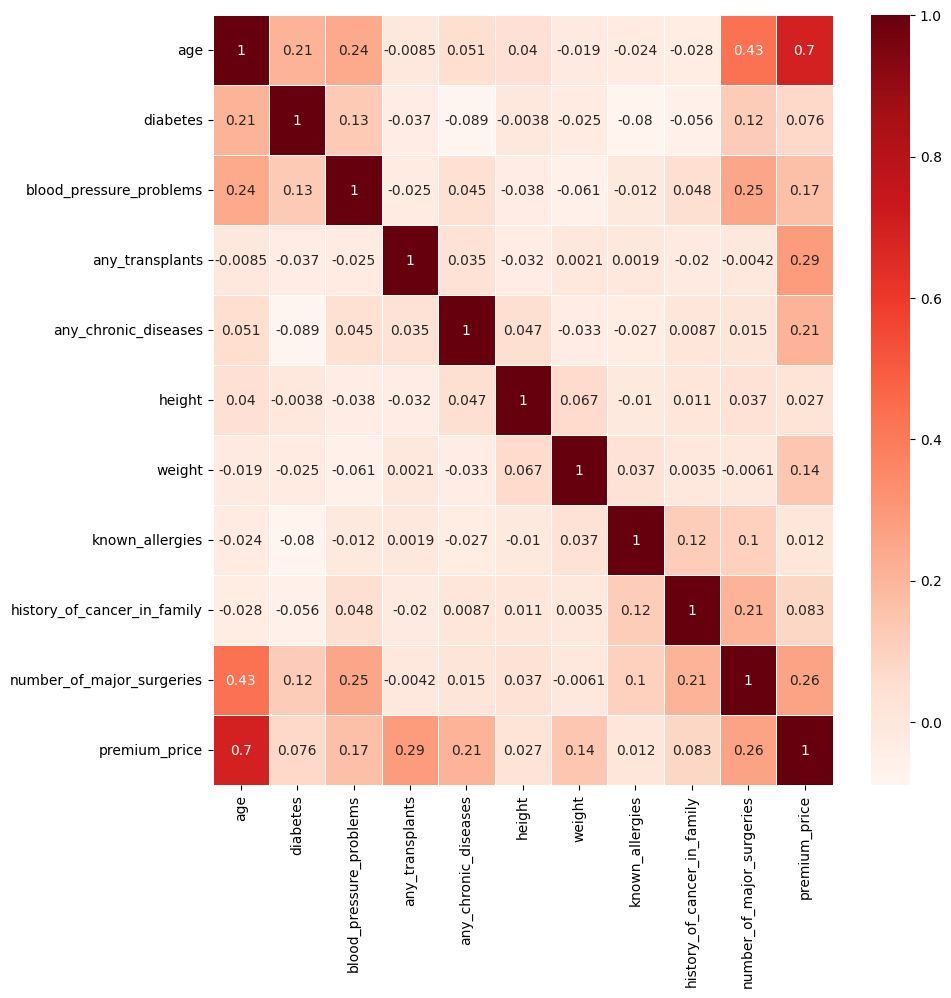

In [175]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True,linewidths=.5, cmap="Reds")

A scatter plot is used to show the relationship between height and weight.

/tmp/ipykernel_1707/1466803679.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(data=df, x=var, y="premium_price", s=100, palette="deep")


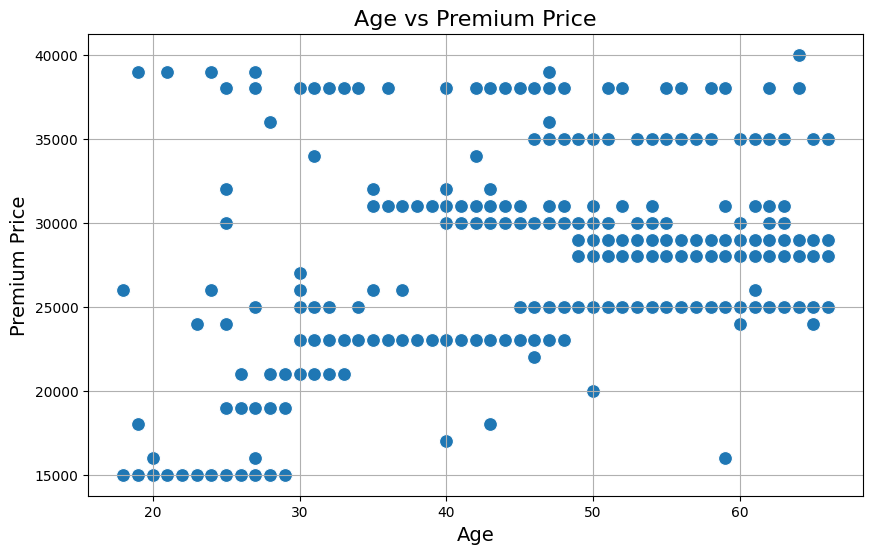

/tmp/ipykernel_1707/1466803679.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(data=df, x=var, y="premium_price", s=100, palette="deep")


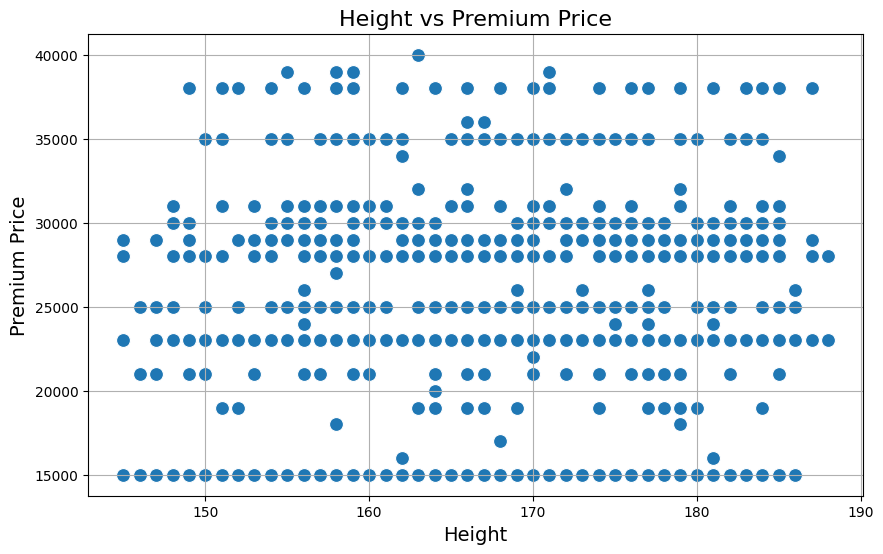

/tmp/ipykernel_1707/1466803679.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(data=df, x=var, y="premium_price", s=100, palette="deep")


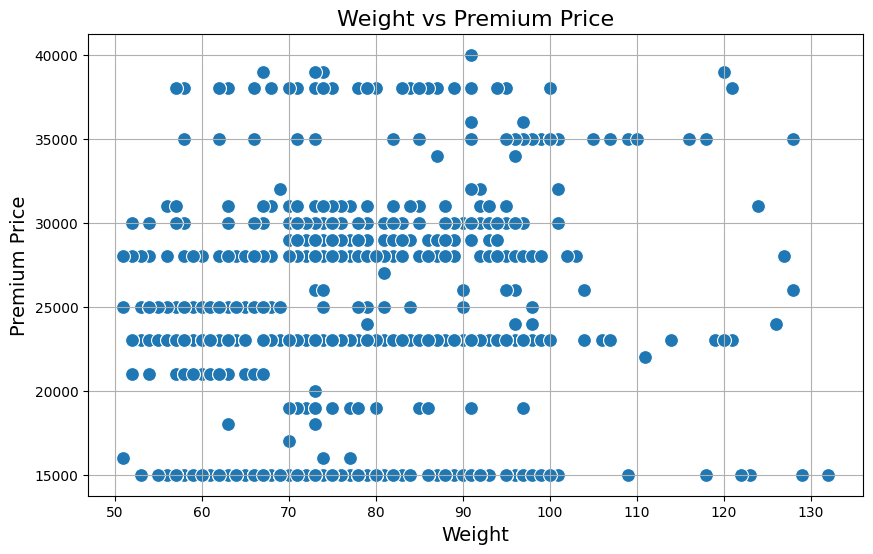

In [176]:
def plot_scatter_for_numerical_variables(df, numerical_variables):
    for var in numerical_variables:
        if var != "premium_price":
            plt.figure(figsize=(10, 6))
            scatter = sns.scatterplot(data=df, x=var, y="premium_price", s=100, palette="deep")
            plt.title(f"{var.capitalize()} vs Premium Price", fontsize=16)
            plt.xlabel(f"{var.capitalize()}", fontsize=14)
            plt.ylabel("Premium Price", fontsize=14)
            plt.grid(True)
            plt.show()

plot_scatter_for_numerical_variables(df, numerical_features)

Distribution of age

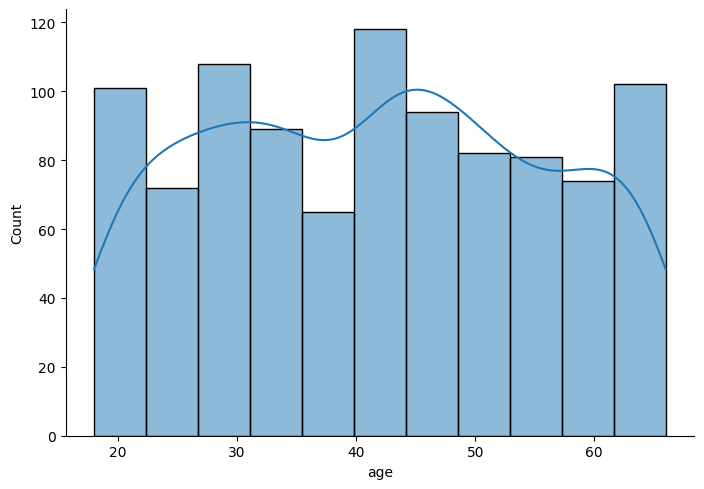

In [177]:
sns.displot(x='age',data=df,aspect=10/7,kde=True)

Distribution of price

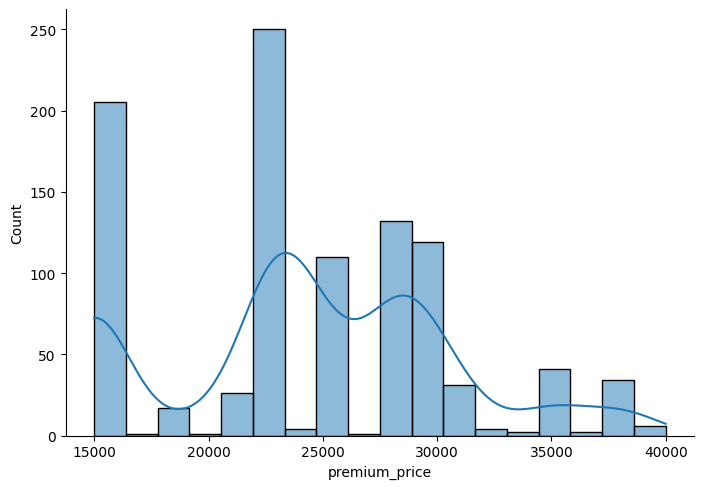

In [178]:
sns.displot(x='premium_price',data=df,aspect=10/7,kde=True)

Feature Engineering

In [179]:
#Creating salary-bins to visualize distribution of Premium Price and Age

pr_lab=['low','average','high']
df['premium_label']=pr_bins=pd.cut(df['premium_price'],bins=3,labels=pr_lab,precision=0)
df['age_label']=pr_bins=pd.cut(df['age'],bins=3,labels=pr_lab,precision=0)
df['weight_label']=pr_bins=pd.cut(df['weight'],bins=3,labels=pr_lab,precision=0)
df['height_label']=pr_bins=pd.cut(df['height'],bins=3,labels=pr_lab,precision=0)

print("Premium Price Bins:", pd.cut(df['premium_price'], bins=3).unique().sort_values())
print("Age Bins:", pd.cut(df['age'], bins=3).unique().sort_values())
print("Weight Bins:", pd.cut(df['weight'], bins=3).unique().sort_values())
print("Height Bins:", pd.cut(df['height'], bins=3).unique().sort_values())

Premium Price Bins: [(14975.0, 23333.333], (23333.333, 31666.667], (31666.667, 40000.0]]
Categories (3, interval[float64, right]): [(14975.0, 23333.333] < (23333.333, 31666.667] < (31666.667, 40000.0]]
Age Bins: [(17.952, 34.0], (34.0, 50.0], (50.0, 66.0]]
Categories (3, interval[float64, right]): [(17.952, 34.0] < (34.0, 50.0] < (50.0, 66.0]]
Weight Bins: [(50.919, 78.0], (78.0, 105.0], (105.0, 132.0]]
Categories (3, interval[float64, right]): [(50.919, 78.0] < (78.0, 105.0] < (105.0, 132.0]]
Height Bins: [(144.957, 159.333], (159.333, 173.667], (173.667, 188.0]]
Categories (3, interval[float64, right]): [(144.957, 159.333] < (159.333, 173.667] < (173.667, 188.0]]


In [180]:
df.columns

Index(['age', 'diabetes', 'blood_pressure_problems', 'any_transplants',
       'any_chronic_diseases', 'height', 'weight', 'known_allergies',
       'history_of_cancer_in_family', 'number_of_major_surgeries',
       'premium_price', 'premium_label', 'age_label', 'weight_label',
       'height_label'],
      dtype='object')

In [181]:
df.head(3)

,age,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,height,weight,known_allergies,history_of_cancer_in_family,number_of_major_surgeries,premium_price,premium_label,age_label,weight_label,height_label
0,45,0,0,0,0,155,57,0,0,0,25000,average,average,low,low
1,60,1,0,0,0,180,73,0,0,0,29000,average,high,low,high
2,36,1,1,0,0,158,59,0,0,1,23000,low,average,low,low


Number of people in each premium-label based on their age-group

<Axes: xlabel='premium_label', ylabel='count'>

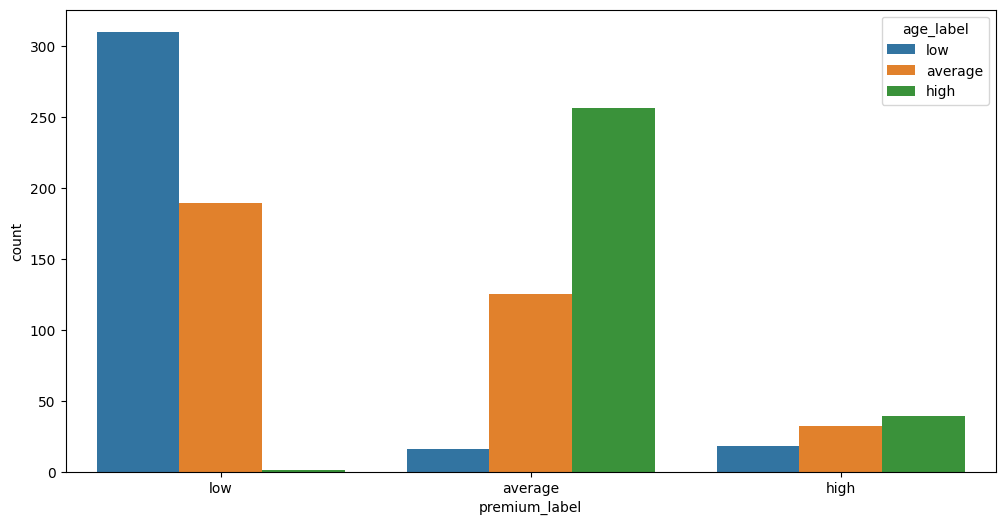

In [182]:
fig,ax=plt.subplots(figsize=(12,6))
sns.countplot(x='premium_label',hue='age_label',data=df,ax=ax)

Avg. price paid by people in each age category for their health insurance

/tmp/ipykernel_1707/3117972411.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['age_label'])['premium_price'].mean().plot(kind='bar')


<Axes: xlabel='age_label'>

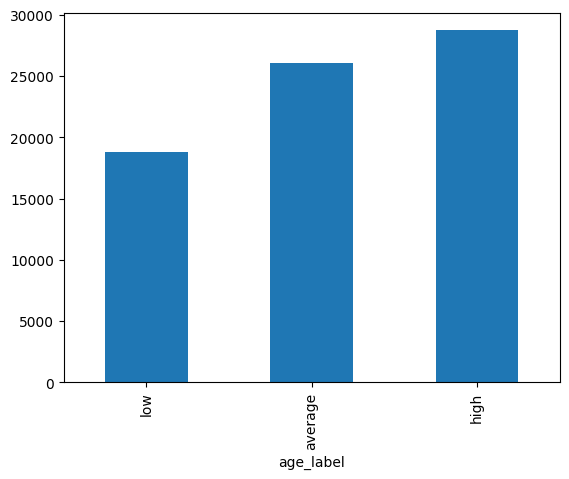

In [183]:
df.groupby(['age_label'])['premium_price'].mean().plot(kind='bar')

Converting new categorical columns to numeric ones

In [184]:
df.drop(['premium_label','age','height','weight'],axis=1,inplace=True)
df = pd.get_dummies(data=df,columns=['age_label','weight_label', 'height_label'])

In [185]:
df.columns

Index(['diabetes', 'blood_pressure_problems', 'any_transplants',
       'any_chronic_diseases', 'known_allergies',
       'history_of_cancer_in_family', 'number_of_major_surgeries',
       'premium_price', 'age_label_low', 'age_label_average', 'age_label_high',
       'weight_label_low', 'weight_label_average', 'weight_label_high',
       'height_label_low', 'height_label_average', 'height_label_high'],
      dtype='object')

In [186]:
df.dtypes

diabetes                       int64
blood_pressure_problems        int64
any_transplants                int64
any_chronic_diseases           int64
known_allergies                int64
history_of_cancer_in_family    int64
number_of_major_surgeries      int64
premium_price                  int64
age_label_low                   bool
age_label_average               bool
age_label_high                  bool
weight_label_low                bool
weight_label_average            bool
weight_label_high               bool
height_label_low                bool
height_label_average            bool
height_label_high               bool
dtype: object

In [187]:
# List of columns to be one-hot encoded
columns_to_encode = ['diabetes', 'blood_pressure_problems', 'any_transplants', 'any_chronic_diseases', 'known_allergies', 'history_of_cancer_in_family', 'number_of_major_surgeries']

# Perform one-hot encoding
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

# Display the first few rows of the encoded dataframe
df.head()

,premium_price,age_label_low,age_label_average,age_label_high,weight_label_low,weight_label_average,weight_label_high,height_label_low,height_label_average,height_label_high,diabetes_1,blood_pressure_problems_1,any_transplants_1,any_chronic_diseases_1,known_allergies_1,history_of_cancer_in_family_1,number_of_major_surgeries_1,number_of_major_surgeries_2,number_of_major_surgeries_3
0,25000,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,29000,False,False,True,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False
2,23000,False,True,False,True,False,False,True,False,False,True,True,False,False,False,False,True,False,False
3,28000,False,False,True,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False
4,23000,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False


### Feature importance (MSI)

This section of the code is responsible for scaling the dataset.
Scaling is a crucial step in data preprocessing for machine learning models.
It ensures that all features contribute equally to the model's performance by normalizing the range of the data.
This helps in improving the convergence speed of gradient descent and the overall performance of the model.
Common scaling techniques include Standardization (z-score normalization) and Min-Max scaling.

In [188]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
xsc=sc.fit_transform(df)
xsc=pd.DataFrame(xsc,columns=df.columns)

Selecting top 15 features which are aligned with premium-price

In [189]:
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(xsc, xsc['premium_price'])
mi_scores = pd.Series(mi_scores, name="MI Scores",index=xsc.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores.round(2)

mi_scores_filtered = mi_scores[mi_scores > 0]
print(mi_scores_filtered)

premium_price                    2.179255
age_label_low                    0.379849
age_label_high                   0.371820
number_of_major_surgeries_2      0.320479
age_label_average                0.261124
any_chronic_diseases_1           0.205668
any_transplants_1                0.153855
number_of_major_surgeries_1      0.119465
weight_label_low                 0.100289
history_of_cancer_in_family_1    0.082938
number_of_major_surgeries_3      0.053615
weight_label_average             0.052568
blood_pressure_problems_1        0.035527
diabetes_1                       0.019284
known_allergies_1                0.016422
weight_label_high                0.015077
height_label_average             0.012389
height_label_low                 0.006503
height_label_high                0.004457
Name: MI Scores, dtype: float64


In [190]:
features = list((mi_scores_filtered).index)
df_final=df[features]

### Setting up the validation framework

In [191]:
from sklearn.model_selection import train_test_split

# Split the original dataframe 'df' into two parts: 
# 'df_full_train' (80% of the data) and 'df_test' (20% of the data)
df_full_train, df_test = train_test_split(df_final, test_size=0.2, random_state=1)

# Further split 'df_full_train' into 'df_train' (75% of df_full_train) 
# and 'df_val' (25% of df_full_train)
# This means 'df_train' is 60% of the original data and 'df_val' is 20% of the original data
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [192]:
len(df_train), len(df_val), len(df_test)

(591, 197, 198)

In [193]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.premium_price.values
y_val = df_val.premium_price.values
y_test = df_test.premium_price.values

del df_train['premium_price']   
del df_val['premium_price']
del df_test['premium_price']

### Train models

In [194]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [195]:
def evaluate_model_performance(regressor, model_name):
    regressor.fit(df_train, y_train)
    
    # Evaluate on validation set
    y_val_pred = regressor.predict(df_val)
    print(f"Mean Squared Error on validation set for {model_name} is: ", mean_squared_error(y_val, y_val_pred))
    
    return regressor

In [196]:
linear_regressor = LinearRegression()
linear_model = evaluate_model_performance(linear_regressor, "Linear Regression")

Mean Squared Error on validation set for Linear Regression is:  14931007.675126903


In [197]:
lasso = Lasso()
lasso_model = evaluate_model_performance(lasso, "Lasso Regression")

Mean Squared Error on validation set for Lasso Regression is:  14842253.732909212


In [198]:
ridge= Ridge()
ridge_model = evaluate_model_performance(ridge, "Lasso Regression")

Mean Squared Error on validation set for Lasso Regression is:  14789872.60820354


In [199]:
# Hyperparameter tuning for Lasso and Ridge

# Define alpha values to test
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Manually tune Lasso
print("Tuning Lasso:")
best_alpha_lasso = None
best_mse_lasso = float('inf')
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=1)
    lasso.fit(df_train, y_train)
    y_val_pred = lasso.predict(df_val)
    mse = mean_squared_error(y_val, y_val_pred).round(2)
    if mse < best_mse_lasso:
        best_mse_lasso = mse
        best_alpha_lasso = alpha
print(f"Best Alpha for Lasso: {best_alpha_lasso}, MSE: {best_mse_lasso}")

# Manually tune Ridge
print("\nTuning Ridge:")
best_alpha_ridge = None
best_mse_ridge = float('inf')
for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=1)
    ridge.fit(df_train, y_train)
    y_val_pred = ridge.predict(df_val)
    mse = mean_squared_error(y_val, y_val_pred).round(2)
    if mse < best_mse_ridge:
        best_mse_ridge = mse
        best_alpha_ridge = alpha
print(f"Best Alpha for Ridge: {best_alpha_ridge}, MSE: {best_mse_ridge}")

Tuning Lasso:


Best Alpha for Lasso: 10, MSE: 14808058.57

Tuning Ridge:
Best Alpha for Ridge: 1, MSE: 14789872.61


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.477e+08, tolerance: 2.290e+06
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.478e+08, tolerance: 2.290e+06
  model = cd_fast.enet_coordinate_descent(


In [200]:
random_forest = RandomForestRegressor(n_estimators=100, criterion="squared_error", random_state=1)
random_forest_model = evaluate_model_performance(random_forest, "Random Forest Regressor")

Mean Squared Error on validation set for Random Forest Regressor is:  18624738.688261442


GridSearchCV is a a tool that helps you find the best hyperparameters for a specific model by trying different combinations of the hyperparameters and evaluating the performance (e.g., using Mean Squared Error).

In the code below: 

GridSearchCV is searching for the best hyperparameters for the RandomForestRegressor model.
It evaluates each combination of hyperparameters using cross-validation (cv=5), which splits the training data into 5 subsets (folds), trains the model on 4 of them, and validates on the remaining one.

In [201]:
# Random forest hyperparameters tuning

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],  # The number of features to consider when looking for the best split
}

# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(random_state=1)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit grid search
grid_search.fit(df_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
val_mse = mean_squared_error(y_val, best_model.predict(df_val))
print("Validate MSE with best model: ", val_mse)

Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Validate MSE with best model:  15611439.471340833


In [202]:
dtree = DecisionTreeRegressor(criterion="squared_error", max_features="sqrt")
dtree_model = evaluate_model_performance(dtree, "Decision Tree Regressor")

Mean Squared Error on validation set for Decision Tree Regressor is:  33473435.595335666


In [203]:
xgb = XGBRegressor(n_estimators=100, max_depth=4)
xgb_model = evaluate_model_performance(xgb,  "XGboost Regressor")

Mean Squared Error on validation set for XGboost Regressor is:  19626297.453610115


The chosen model is *Ridge* 
Tuning Ridge:
Best Alpha for Ridge: 1, MSE: 14789872.61

### Use the model on the test set

In [217]:
#Concatenate the training and validation dataframes
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = df_full_train
X_full_train.shape

(788, 18)

In [218]:
y_full_train = np.concatenate([y_train, y_val]) 
y_full_train.shape

(788,)

In [219]:
df_test.shape

(198, 18)

In [220]:
y_test.shape

(198,)

In [229]:
alpha=1
ridge = Ridge(alpha=alpha, random_state=1)
ridge.fit(X_full_train, y_full_train)
y_test_pred = ridge.predict(df_test)
mse = mean_squared_error(y_test, y_test_pred).round(2)

print(f"Mean Squared Error on test set for Ridge Regression is: {mse}")

Mean Squared Error on test set for Ridge Regression is: 17749944.51


In [226]:
# Select a single row from the test set
single_row = df_test.iloc[0]

# Get the actual premium price for the selected row
actual_premium_price = y_test[0]

# Reshape the single row to match the expected input shape for the model
single_row_reshaped = single_row.values.reshape(1, -1)

# Predict the premium price using the trained Ridge model
predicted_premium_price = ridge.predict(single_row_reshaped)[0]

print(f"Actual Premium Price: {actual_premium_price}")
print(f"Predicted Premium Price: {predicted_premium_price}")

Actual Premium Price: 28000
Predicted Premium Price: 27903.251218704434


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


### Save the model

In [233]:
import pickle
output_file = f'ridge_model.bin'
output_file

'ridge_model.bin'

In [234]:
# Open the file in write-binary mode
f_out = open(output_file, 'wb') 

# Serialize and save the DictVectorizer and model to the file
pickle.dump(ridge, f_out)

# Close the file
f_out.close()

In [236]:
!ls -lh *.bin

-rw-rw-rw- 1 codespace codespace 1.1K Nov 26 02:51 ridge_model.bin


Load the model

In [237]:
input_file = 'ridge_model.bin'

In [238]:
with open(input_file, 'rb') as f_in: 
    model = pickle.load(f_in)

In [239]:
model

Ridge(alpha=1, random_state=1)